<a href="https://colab.research.google.com/github/hsebasa/SeriesHW/blob/main/GroHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!git init
!git remote add origin https://github.com/hsebasa/SeriesHW.git
!git fetch --all
!git checkout HEAD data

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
Fetching origin
HEAD is now at 5913bfb Added csv files to git


In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dates_format = '%Y-%m-%d'

def convert_dates_df(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], format=dates_format).dt.tz_localize(None)
  return df

In [ ]:
info_start_date = pd.Timestamp('2014-01-01')
info_end_date = pd.Timestamp('2022-03-13')

prod_start_date = pd.Timestamp('2015-01-01')
prod_end_date = pd.Timestamp('2020-12-01')

test_start_date = pd.Timestamp('2021-01-01')
test_end_date = pd.Timestamp('2021-12-01')

regions_ids = {93, 94, 95, 97, 98, 99, 102, 103, 104, 105}

In [ ]:
def check_regions(df, col_reg='region_id'):
  regions = set(df.groupby(col_reg).groups.keys())
  assert regions == regions_ids

In [ ]:
def month_diff(s, start_date=info_start_date):
  return 12 * (s.dt.year - start_date.year) + (s.dt.month - start_date.month)

In [ ]:
def days_diff(s, start_date=info_start_date):
  return (s - start_date).dt.days

In [ ]:
def normalize_minmax(s):
  return (s-s.min())/(s.max()-s.min())

def normalize_trunc(s):
  return (s-s.min())/s.std()
  
def normalize_norm(s):
  return (s-s.mean())/s.std()

In [ ]:
def check_number_days(df, col_days='days'):
  """
  This function checks that the number of days for each region is the same, i.e.
  there are no missing days.
  """
  total_days = (info_end_date-info_start_date).days + 1
  days_per_region = df.groupby('region_id')[col_days].nunique()
  if (days_per_region != total_days).any():
    warnings.warn('some regions have a different number of days')

In [ ]:
def check_number_months(df, col_months='months', 
                        start_date=info_start_date, end_date=info_end_date):
  """
  This function checks that the number of months given for each region 
  is the same, i.e. there are no missing months.
  """
  years = (end_date.year-start_date.year)
  total_months = 12*years + (end_date.month-start_date.month)+1
  months_per_region = df.groupby('region_id')[col_months].nunique()
  
  assert not (months_per_region != total_months).any(), 'some regions have a different number of months'

In [ ]:
def summarize_month(df, col_name):
  def quant(q):
    return lambda x: x.quantile(q)
  def quant_diff(q1, q2):
    return lambda x: x.quantile(q2)-x.quantile(q1)

  groups = df.groupby(['region_id', 'months'])
  res = groups[col_name].agg(q1=quant(0.25), q2=quant(0.5), 
                             q3=quant(0.75), q4=quant(0.9),
                             d1=quant_diff(0.25, 0.75),
                             mx='max', mn='min', avg='mean')
  return res

In [ ]:
def inpute(df, radius=1):
  """
  https://stackoverflow.com/questions/57393103/pandas-replace-nans-with-mean-of-n-nearest-non-empty-values-in-column
  """
  a = df.rolling(radius).mean()
  b = df.iloc[::-1].rolling(radius).mean()

  c = a.fillna(b).fillna(df).interpolate(method='nearest').ffill().bfill()
  df = df.fillna(c)
  return df

# Preprocess

## Precipitation

In [ ]:
raw_precipitation = pd.read_csv("data/Daily Precipitation.csv")
convert_dates_df(raw_precipitation, ('start_date', 'end_date'))
raw_precipitation.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
precip               float64
region_id              int64
dtype: object

In [ ]:
raw_precipitation.isnull().any()

start_date    False
end_date      False
precip        False
region_id     False
dtype: bool

In [ ]:
check_regions(raw_precipitation)

In [ ]:
raw_precipitation['days'] = days_diff(raw_precipitation['end_date'])
raw_precipitation['months'] = month_diff(raw_precipitation['end_date'])

In [ ]:
check_number_days(raw_precipitation, col_days='days')
check_number_months(raw_precipitation, col_months='months')

In [ ]:
raw_precipitation['precip'].describe()

count    29940.000000
mean         7.275856
std          9.468009
min          0.000000
25%          1.112265
50%          4.340616
75%         10.086396
max        151.307444
Name: precip, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc56123aa90>]],
      dtype=object)

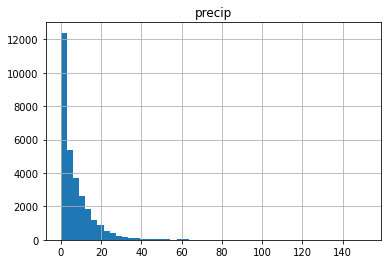

In [ ]:
raw_precipitation.hist('precip', bins=50)

In [ ]:
raw_precipitation['precip_mod'] = normalize_trunc(raw_precipitation['precip'])

In [ ]:
precipitation = summarize_month(raw_precipitation, col_name='precip_mod')
precipitation

q1        q2        q3        q4        d1         mx  \
region_id months                                                                
93        0       0.001790  0.015184  0.054487  0.678576  0.052697   3.466796   
          1       0.000606  0.004286  0.013498  0.101471  0.012893   0.397929   
          2       0.000791  0.027224  0.567057  2.060341  0.566265   7.100018   
          3       0.683134  1.049794  1.393519  2.065683  0.710384   3.185755   
          4       0.395862  0.723557  1.296233  2.210631  0.900370   3.092338   
...                    ...       ...       ...       ...       ...        ...   
105       94      0.569809  1.200769  2.619505  3.609618  2.049696   6.288127   
          95      0.028551  0.180851  2.018945  5.064177  1.990395   7.721921   
          96      0.006563  0.011049  0.020848  0.115120  0.014284   0.336838   
          97      0.098115  0.609065  3.455432  8.995157  3.357317  15.980915   
          98      0.009739  0.224382  0.287254  1.534043  0.277516   2.746789   

                        mn       avg  
region_id months                      
93        0       0.000040  0.268457  
          1       0.000025  0.034433  
          2       0.000007  0.655733  
          3       0.051613  1.101957  
          4       0.143641  0.967546  
...                    ...       ...  
105       94      0.086747  1.695945  
          95      0.000033  1.529348  
          96      0.000544  0.043608  
          97      0.010405  2.839470  
          98      0.002234  0.494197  

[990 rows x 8 columns]

## Soil Moisture

In [ ]:
raw_moisture = pd.read_csv("data/Daily Soil Mositure.csv")
convert_dates_df(raw_moisture, ('start_date', 'end_date'))
raw_moisture.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
smos                 float64
region_id              int64
dtype: object

In [ ]:
raw_moisture.isnull().any()

start_date    False
end_date      False
smos          False
region_id     False
dtype: bool

In [ ]:
check_regions(raw_moisture)

In [ ]:
raw_moisture['days'] = days_diff(raw_moisture['end_date'])
raw_moisture['months'] = month_diff(raw_moisture['end_date'])

In [ ]:
check_number_days(raw_moisture, col_days='days')
check_number_months(raw_moisture, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [ ]:
raw_moisture['smos'].describe()

count    29603.000000
mean         0.266492
std          0.092495
min          0.004318
25%          0.203135
50%          0.260049
75%          0.321686
max          0.814535
Name: smos, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc560709d10>]],
      dtype=object)

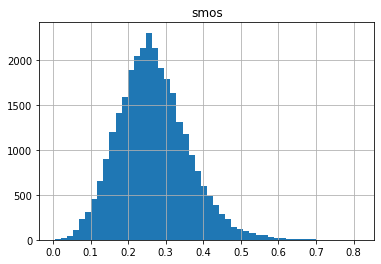

In [ ]:
raw_moisture.hist('smos', bins=50)

In [ ]:
raw_moisture['smos_mod'] = normalize_trunc(raw_moisture['smos'])

In [ ]:
moisture = summarize_month(raw_moisture, col_name='smos_mod')
moisture

q1        q2        q3        q4        d1        mx  \
region_id months                                                               
93        0       2.489719  3.071580  3.353687  4.052136  0.863968  4.809357   
          1       2.510807  2.939144  3.177882  3.729588  0.667075  4.041195   
          2       2.073835  2.726214  3.225006  3.898020  1.151171  4.036038   
          3       2.580308  2.949137  3.529644  3.714432  0.949336  4.966163   
          4       2.279184  2.649666  3.001700  3.528059  0.722516  3.625854   
...                    ...       ...       ...       ...       ...       ...   
105       94      4.031834  4.225898  4.339424  4.789530  0.307591  6.477209   
          95      4.266989  4.650765  4.847240  5.445253  0.580251  5.615409   
          96      4.059170  4.528208  4.875800  5.333497  0.816630  5.415463   
          97      4.374657  4.902742  5.480834  5.649711  1.106177  5.756363   
          98      4.480986  4.738722  4.738722  5.247543  0.257735  5.756363   

                        mn       avg  
region_id months                      
93        0       1.908876  3.065612  
          1       1.811537  2.904615  
          2       1.609224  2.706107  
          3       1.405275  2.958206  
          4       1.320344  2.531482  
...                    ...       ...  
105       94      3.028356  4.253488  
          95      3.548082  4.618796  
          96      3.216714  4.491754  
          97      4.068222  4.899098  
          98      4.395075  4.793780  

[990 rows x 8 columns]

## Temperature

In [ ]:
raw_temperature = pd.read_csv("data/Daily Temperature.csv")
convert_dates_df(raw_temperature, ('start_date', 'end_date'))
raw_temperature.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
temp                 float64
region_id              int64
dtype: object

In [ ]:
raw_temperature.isnull().any()

start_date    False
end_date      False
temp          False
region_id     False
dtype: bool

In [ ]:
check_regions(raw_temperature)

In [ ]:
raw_temperature['days'] = days_diff(raw_temperature['end_date'])
raw_temperature['months'] = month_diff(raw_temperature['end_date'])

In [ ]:
check_number_days(raw_temperature, col_days='days')
check_number_months(raw_temperature, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [ ]:
raw_temperature['temp'].describe()

count    12930.000000
mean        26.542191
std          2.494511
min         17.031505
25%         24.843353
50%         26.591613
75%         28.185999
max         37.295265
Name: temp, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc55fc6db50>]],
      dtype=object)

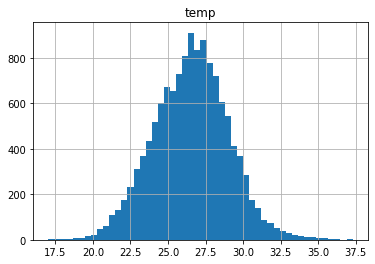

In [ ]:
raw_temperature.hist('temp', bins=50)

In [ ]:
raw_temperature['temp_mod'] = normalize_norm(raw_temperature['temp'])

In [ ]:
temperature = summarize_month(raw_temperature, col_name='temp_mod')
temperature

q1        q2        q3        q4        d1        mx  \
region_id months                                                               
93        0      -0.946967 -0.797890  0.016015  0.536725  0.962982  1.465003   
          1      -0.275011 -0.083892  0.730455  0.992489  1.005466  1.295286   
          2       0.629110  1.568792  1.727607  2.176111  1.098497  2.873767   
          3      -0.758691  0.137846  0.386069  0.800249  1.144760  0.890482   
          4      -0.342178 -0.035840  0.312780  0.867670  0.654958  1.302526   
...                    ...       ...       ...       ...       ...       ...   
105       94     -0.587641 -0.449841 -0.158974  0.100345  0.428667  0.227783   
          95     -1.030390 -0.445485 -0.194331 -0.104684  0.836059 -0.093228   
          96     -1.051037 -0.633447 -0.258504  0.294235  0.792533  0.705863   
          97     -0.044954  0.256677  0.322673  0.361022  0.367627  0.386587   
          98     -0.206361 -0.181748  0.226907  0.734323  0.433267  1.072600   

                        mn       avg  
region_id months                      
93        0      -1.158150 -0.424946  
          1      -1.805094  0.042331  
          2      -1.144758  1.137256  
          3      -1.856950 -0.109978  
          4      -0.814847  0.040320  
...                    ...       ...  
105       94     -1.705992 -0.488754  
          95     -1.732038 -0.675368  
          96     -2.369690 -0.610303  
          97     -0.470610  0.090075  
          98     -0.857730  0.010733  

[990 rows x 8 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc55fb1a710>],
      dtype=object)

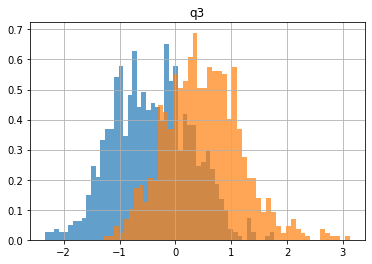

In [ ]:
ax = plt.gca()
temperature.hist('q1', bins=50, ax=ax, density=True, alpha=0.7)
temperature.hist('q3', bins=50, ax=ax, density=True, alpha=0.7)

## NDVI

In [ ]:
raw_ndvi = pd.read_csv("data/Eight Day NDVI.csv")
convert_dates_df(raw_ndvi, ('start_date', 'end_date'))
raw_ndvi.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
ndvi                 float64
region_id              int64
dtype: object

In [ ]:
raw_ndvi.isnull().any()

start_date    False
end_date      False
ndvi          False
region_id     False
dtype: bool

In [ ]:
check_regions(raw_ndvi)

In [ ]:
raw_ndvi['days'] = days_diff(raw_ndvi['end_date'])
raw_ndvi['months'] = month_diff(raw_ndvi['end_date'])

In [ ]:
months = set(range(99))
missing_months_per_region = raw_ndvi.groupby(['region_id']).apply(lambda df: months-set(df['months'].to_list()))
missing_months_per_region

region_id
93             {34}
94               {}
95               {}
97             {34}
98             {34}
99               {}
102              {}
103              {}
104    {34, 83, 94}
105        {48, 34}
dtype: object

In [ ]:
raw_ndvi['ndvi'].describe()

count    3338.000000
mean        0.798429
std         0.033146
min         0.573141
25%         0.784141
50%         0.805861
75%         0.821163
max         0.862471
Name: ndvi, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc55fc52c50>]],
      dtype=object)

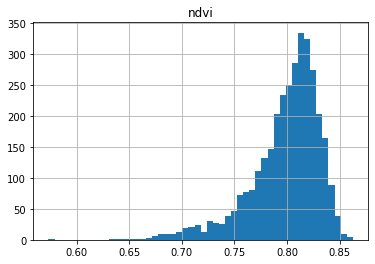

In [ ]:
raw_ndvi.hist('ndvi', bins=50)

In [ ]:
raw_ndvi['ndvi_mod'] = normalize_norm(raw_ndvi['ndvi'])

In [ ]:
mean_ndvi = raw_ndvi.groupby(['region_id', 'months'])['ndvi'].mean()
ndvi_stacked = inpute(mean_ndvi.unstack(level=1))

In [ ]:
ndvi = ndvi_stacked.stack(level=0).to_frame('avg')
ndvi

avg
region_id months          
93        0       0.718269
          1       0.767647
          2       0.743301
          3       0.807792
          4       0.813410
...                    ...
105       94      0.798444
          95      0.811967
          96      0.804896
          97      0.790585
          98      0.795875

[990 rows x 1 columns]

## Production quantity

In [ ]:
raw_prod = pd.read_csv("data/Production Quantity.csv")
convert_dates_df(raw_prod, ('start_date', 'end_date'))
raw_prod.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
prod                   int64
region_id              int64
dtype: object

In [ ]:
raw_prod.isnull().any()

start_date    False
end_date      False
prod          False
region_id     False
dtype: bool

In [ ]:
check_regions(raw_prod)

In [ ]:
raw_prod['months'] = month_diff(raw_prod['end_date'], start_date=prod_start_date)

In [ ]:
check_number_months(raw_prod, start_date=prod_start_date, end_date=prod_end_date)

In [ ]:
raw_prod['prod'].describe()

count       720.000000
mean     159014.201389
std      142882.722751
min       10215.000000
25%       35445.500000
50%       91945.500000
75%      269946.000000
max      593579.000000
Name: prod, dtype: float64

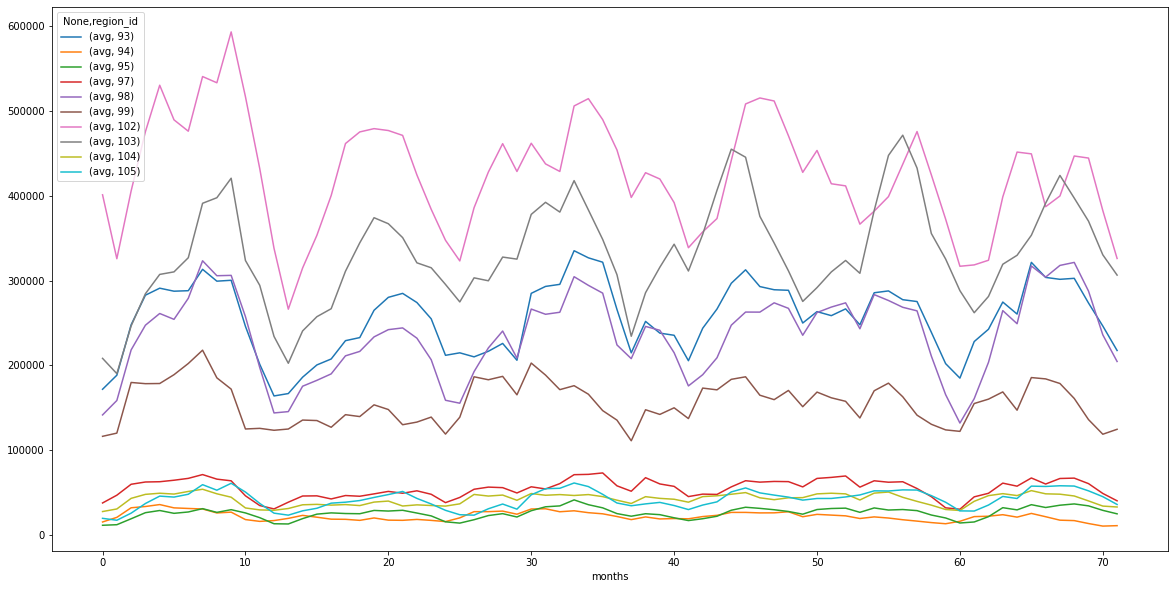

In [ ]:
prod = raw_prod.groupby(['region_id', 'months'])['prod'].mean().to_frame('avg')
prod_stacked = prod.unstack(level=0)
prod_stacked.plot(figsize=(20, 10))

## Data

In [ ]:
precipitation_rn = precipitation.rename(columns={col: col+'_p' for col in precipitation.columns})
moisture_rn = moisture.rename(columns={col: col+'_m' for col in moisture.columns})
temperature_rn = temperature.rename(columns={col: col+'_t' for col in temperature.columns})
ndvi_rn = ndvi.rename(columns={col: col+'_n' for col in ndvi.columns})
prod_rn = ndvi.rename(columns={col: col+'_o' for col in ndvi.columns})

data = precipitation_rn.copy()
for df in [moisture_rn, temperature_rn, ndvi_rn, prod_rn]:
  data = data.merge(df, left_index=True, right_index=True, how='outer')
  print(data.isnull().any().any())

False
False
False
False


In [ ]:
data.columns

Index(['q1_p', 'q2_p', 'q3_p', 'q4_p', 'd1_p', 'mx_p', 'mn_p', 'avg_p', 'q1_m',
       'q2_m', 'q3_m', 'q4_m', 'd1_m', 'mx_m', 'mn_m', 'avg_m', 'q1_t', 'q2_t',
       'q3_t', 'q4_t', 'd1_t', 'mx_t', 'mn_t', 'avg_t', 'avg_n', 'avg_o'],
      dtype='object')